# Groundwater extraction 

This notebook shows how the different techniques extract the groundwater level information from the borehole profiles.

In [1]:
# Handle the path and cwd
import os
import fitz
from pathlib import Path


In [2]:

# Switch to the root directory of the repo.
%cd ~/swissgeol-boreholes-dataextraction

os.getcwd()

/Users/david.cleres/swissgeol-boreholes-dataextraction


/Users/david.cleres/swissgeol-boreholes-dataextraction/swisstopo/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/Users/david.cleres/swissgeol-boreholes-dataextraction/swisstopo/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/Users/david.cleres/swissgeol-boreholes-dataextraction'

Start with loading data from the ZH dataset as the data is already labeled there.

In [3]:
# input_directory = Path("data/geoquat/test")
# draw_directory = Path("src/stratigraphy/prototyping/data/draw")

input_directory = Path("data/zurich")
draw_directory = Path("src/stratigraphy/prototyping/data/draw")

## Load the GT and DB entry from the S3 File

In [4]:
import json
# filename = "data/geoquat_ground_truth.json"
filename = "data/zurich_ground_truth.json"

with open(filename, 'r') as f:
    data = json.load(f)

## Load the PDF image

In [5]:
# TP Examples: 
# filename = "267123002-bp.pdf"
# filename = "267123021-bp.pdf"  # TODO: elevation needs to be extracted
# filename = "267123055-bp.pdf"
# filename = "268123018-bp.pdf"
# filename = "268124391-bp.pdf"
# filename = "676254009-bp.pdf"
# filename = "679259016-bp.pdf"
# filename = "267123099-bp.pdf"
# filename = "267125314-bp.pdf"  # GW info is on the right side


# FP Examples: 
# filename = "267124070-bp.pdf"  # text extraction did not work ... 
# filename = "267123080-bp.pdf"  # text extraction did not work ... 

# filename = "267123094-bp.pdf"  # missing keyword, only logo

# filename = "267125223-bp.pdf"
# filename = "267125334-bp.pdf" # GT wrong 

# filename = "680244005-bp.pdf"
# filename = "267125312-bp.pdf"
# filename = "268124569-bp.pdf"

filename = "267123002-bp.pdf"

In [6]:
# filter the json for the file name
gt_single_file_data = data[filename]
gt_single_file_data

{'groundwater': [{'date': '2008-09-03', 'depth': 1.48, 'elevation': 457.69}],
 'layers': [{'depth_interval': {'end': None, 'start': None},
   'material_description': 'Humus und erdig-toniger Silt '},
  {'depth_interval': {'end': None, 'start': None},
   'material_description': 'dunkelgrauer, toniger Silt, steif, wenig Sand, wenig Kies (evtl. Auffüllung) '},
  {'depth_interval': {'end': None, 'start': None},
   'material_description': 'grauer, siltiger Kies, reichlich Sand '},
  {'depth_interval': {'end': None, 'start': None},
   'material_description': 'grauer, tonig-siltiger Sand, wenig bis reichlich Kies '},
  {'depth_interval': {'end': None, 'start': None},
   'material_description': 'grauer und graubrauner, stark siltiger Feinsand/Sand, reichlich bis viel Kies, vereinzelt bis wenig Steine ø max. 8 cm '},
  {'depth_interval': {'end': None, 'start': None},
   'material_description': 'grauer, schwach tonig-siltiger Sand/Feinsand, wenig bis reichlich Kies, wenig Steine ø max. 10 cm '},

In [7]:
import logging

from stratigraphy.util.util import read_params
logger = logging.getLogger(__name__)

matching_params = read_params("matching_params.yml")


## Show the document

In [8]:
doc = fitz.open(os.path.join(input_directory, filename))
nb_pages = doc.page_count

print(f"Number of pages: {nb_pages}")

Number of pages: 1


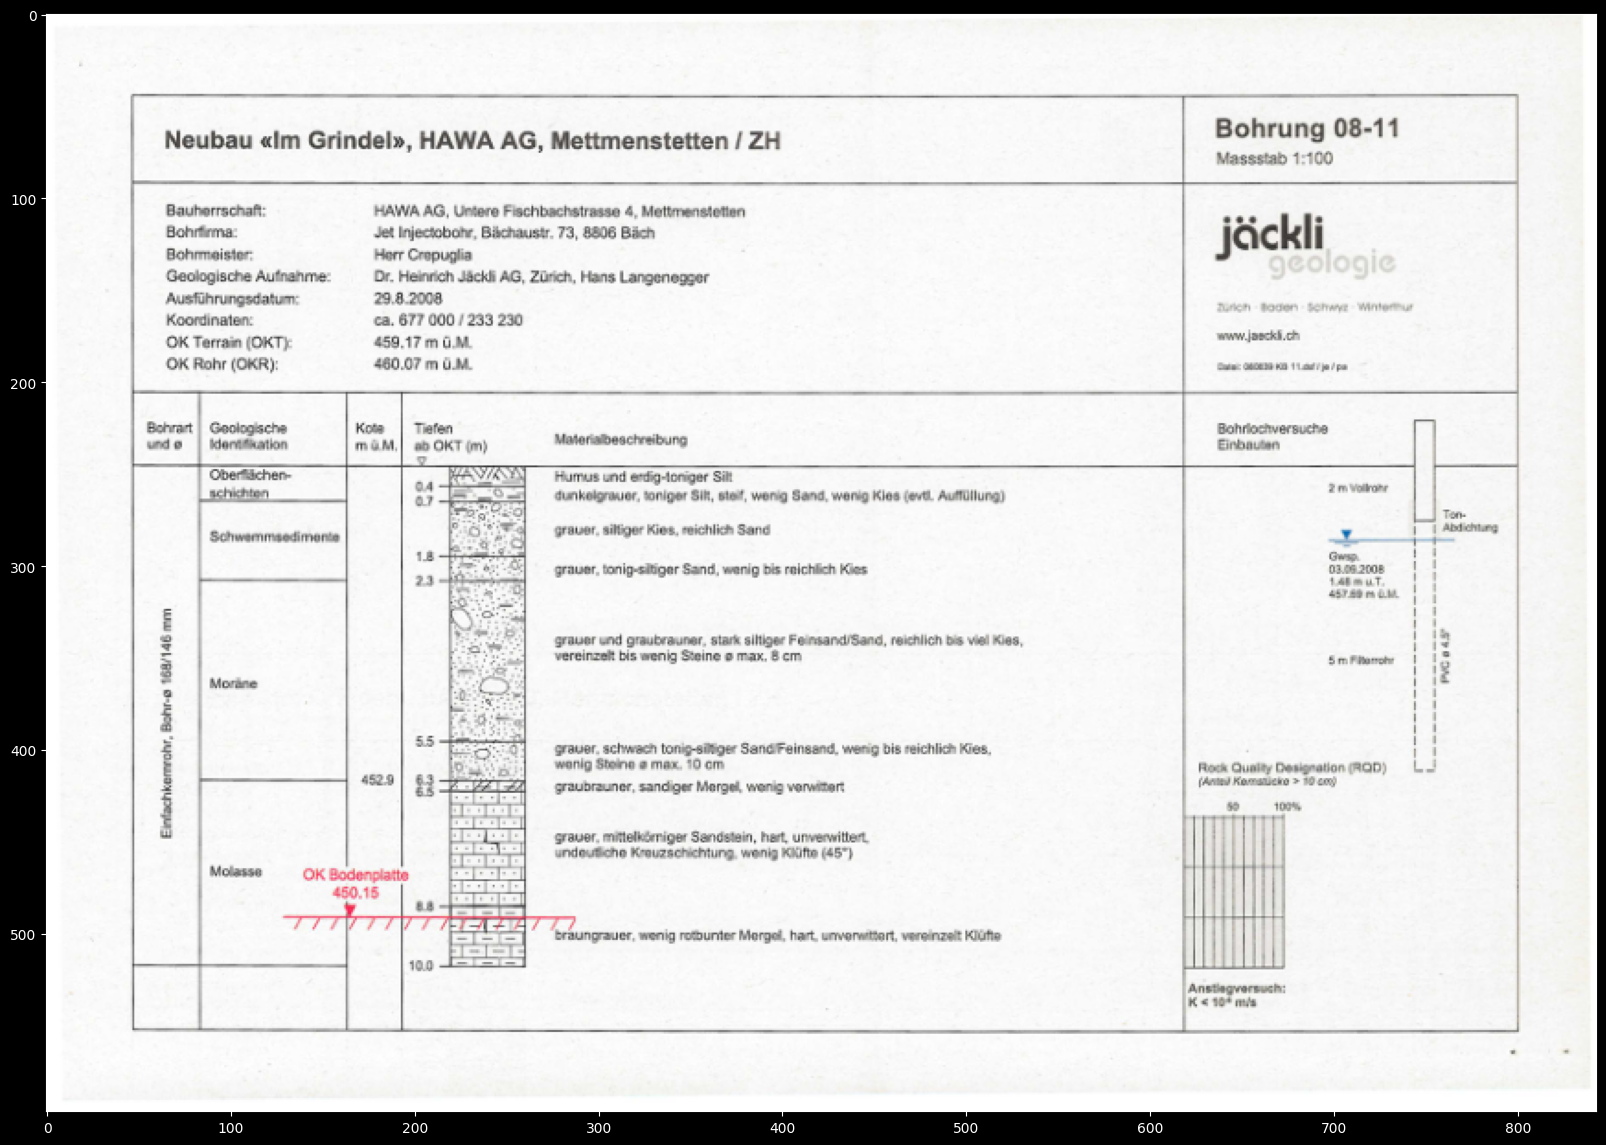

In [9]:
for i in range(nb_pages):    
    page = doc.load_page(i)  # load the page
    pix = page.get_pixmap()  # render page to an image

    # plot the image
    import matplotlib.pyplot as plt
    import numpy as np

    img_array = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, pix.n)

    plt.figure(figsize=(20, 20))
    plt.imshow(img_array)
    plt.show()

# Save the image a PNG

In [10]:
def convert_pdf_to_png(pdf_file: Path, output_directory: Path):
    """Convert pdf files to png files.

    Args:
        input_directory (Path): The input directory containing the pdf files.
        output_directory (Path): The output directory to save the png files.
    """
    if isinstance(pdf_file, str):
        pdf_file = Path(pdf_file)
    if isinstance(output_directory, str):
        output_directory = Path(output_directory)

    document = fitz.open(pdf_file)
    for page_number in range(document.page_count):
        page = document.load_page(page_number)
        image = page.get_pixmap(matrix=fitz.Matrix(3, 3))

        if output_directory is None:
            output_directory = pdf_file.parent
        image.save(output_directory / f"{pdf_file.stem}_{page_number}.png")

        print(f"Page {page_number} saved as {output_directory / pdf_file.stem}_{page_number}.png")


In [11]:
# convert_pdf_to_png(os.path.join(input_directory, filename), None)

## List text by page

In [12]:
from stratigraphy.util.extract_text import extract_text_lines

with fitz.Document(os.path.join(input_directory, filename)) as doc:

    text_in_document = []
    for page in doc:
        text_in_document += extract_text_lines(page)
        page_number = page.number + 1  # page.number is 0-based

        print(f"\n\nPage {page_number} has {len(text_in_document)} lines of text")
        
        for line in text_in_document:
            print(line)



Page 1 has 79 lines of text
TextLine(Neubau Im Grindel, HAWA AG, Mettmenstetten / ZH, Rect(64.91850280761719, 59.80101013183594, 390.92242431640625, 79.0370101928711))
TextLine(Bauherrschaft:, Rect(65.6697006225586, 101.01801300048828, 117.69368743896484, 112.010009765625))
TextLine(Bohrfirma:, Rect(65.70140075683594, 112.90201568603516, 102.59739685058594, 123.89401245117188))
TextLine(Bohrmeister:, Rect(65.64679718017578, 124.9100112915039, 110.99079132080078, 135.90200805664062))
TextLine(Geologische Aufnahme:, Rect(65.50959777832031, 137.59201049804688, 150.8855743408203, 148.58401489257812))
TextLine(Ausführungsdatum:, Rect(65.106201171875, 149.50201416015625, 134.47418212890625, 160.4940185546875))
TextLine(Koordinaten:, Rect(65.72260284423828, 160.92800903320312, 111.08258819580078, 171.92001342773438))
TextLine(OK Terrain (OKT):, Rect(65.66419982910156, 173.45703125, 131.00819396972656, 184.44903564453125))
TextLine(OK Rohr (OKR):, Rect(65.57530212402344, 185.40200805664062, 

## Parse the text in the document

In [13]:
from stratigraphy.util.coordinate_extraction import CoordinateExtractor
from stratigraphy.groundwater.groundwater_extraction import GroundwaterInformation, GroundwaterLevelExtractor
from stratigraphy.util.extract_text import extract_text_lines
from stratigraphy.util.language_detection import detect_language_of_document

logger.info("Processing file: %s", os.path.join(input_directory, filename))

predictions = {}

with fitz.Document(os.path.join(input_directory, filename)) as doc:

    predictions[filename] = {}

    text_in_document = []
    for page in doc:
        text_in_document += extract_text_lines(page)
        page_number = page.number + 1  # page.number is 0-based

    # Find the language of the document
    language = detect_language_of_document(
        doc, matching_params["default_language"], matching_params["material_description"].keys()
    )
    predictions[filename]["language"] = language

    # Extract the coordinates of the borehole
    coordinate_extractor = CoordinateExtractor(doc)
    coordinates = coordinate_extractor.extract_coordinates()
    if coordinates:
        predictions[filename]["metadata"] = {"coordinates": coordinates.to_json()}
    else:
        predictions[filename]["metadata"] = {"coordinates": None}
    
    # Extract the drilling method
    ground_water_extractor = GroundwaterLevelExtractor(doc)
    ground_water = ground_water_extractor.extract_groundwater_information()

    if ground_water:
        predictions[filename]["groundwater_information"] = ground_water.to_dict()
    # else:
    #     predictions[filename]["metadata"]["groundwater_information"] = GroundwaterInformation(
    #         None, None, None, None
    #     ).to_dict()

    predictions[filename]["layers"] = []
    predictions[filename]["page_dimensions"] = [ {"height": page.rect.height, "width": page.rect.width} ]



In [14]:
ground_water

GroundwaterInformation(depth=1.48, measurement_date=datetime.date(2008, 9, 3), elevation=457.69, rect=Rect(697.1820068359375, 290.8680114746094, 736.5300903320312, 319.2550354003906), page=1)

In [15]:
from stratigraphy.benchmark.score import create_predictions_objects

ground_truth_path = "data/zurich_ground_truth.json"
predictions_obj, number_of_truth_values = create_predictions_objects(predictions, ground_truth_path)

# Draw the predictions

In [16]:
predictions_obj[filename].metadata

BoreholeMetaData(coordinates=LV03Coordinate(east=677'000, north=233'230, rect=Rect(178.3300018310547, 160.76702880859375, 255.7219696044922, 171.759033203125), page=1))

In [17]:
from stratigraphy.util.draw import draw_coordinates, draw_groundwater_information, draw_metadata
from stratigraphy.util.predictions import FilePredictions

mlflow_tracking = os.getenv("MLFLOW_TRACKING") == "True"  # Checks whether MLFlow tracking is enabled

def draw_predictions(predictions: list[FilePredictions], directory: Path, out_directory: Path) -> None:
    """Draw predictions on pdf pages.

    Draws various recognized information on the pdf pages present at directory and saves
    them as images in the out_directory.

    The drawn information includes:
        - Depth columns (if available)
        - Depth column entries (if available)
        - Material description columns
        - Material description text blocks
        - Color-coded correctness of the material description text blocks
        - Assignments of material description text blocks to depth intervals (if available)

    Args:
        predictions (dict): Content of the predictions.json file.
        directory (Path): Path to the directory containing the pdf files.
        out_directory (Path): Path to the output directory where the images are saved.
    """
    if directory.is_file():  # deal with the case when we pass a file instead of a directory
        directory = directory.parent
    for file_name, file_prediction in predictions.items():
        logger.info("Drawing predictions for file %s", file_name)
        with fitz.Document(directory / file_name) as doc:
            for page_index, page in enumerate(doc):
                shape = page.new_shape()  # Create a shape object for drawing
                page_number = page_index + 1
                # layers = file_prediction.pages[page_index].layers
                # depths_materials_column_pairs = file_prediction.pages[page_index].depths_materials_columns_pairs
                if page_index == 0:
                    draw_metadata(
                        shape,
                        page.derotation_matrix,
                        page.rotation,
                        file_prediction.metadata.coordinates,
                        file_prediction.metadata_is_correct.get("coordinates"),
                    )
                if file_prediction.metadata.coordinates is not None:
                    draw_coordinates(shape, file_prediction.metadata.coordinates)
                if file_prediction.groundwater_information is not None:
                    draw_groundwater_information(shape, file_prediction.groundwater_information)
                # draw_depth_columns_and_material_rect(page, depths_materials_column_pairs)
                # draw_material_descriptions(page, layers)

                shape.commit()  # Commit all the drawing operations to the page

                tmp_file_path = out_directory / f"{file_name.split(".")[0]}_page{page_number}.png"
                fitz.utils.get_pixmap(page, matrix=fitz.Matrix(2, 2), clip=page.rect).save(tmp_file_path)
                if mlflow_tracking:  # This is only executed if MLFlow tracking is enabled
                    try:
                        import mlflow

                        mlflow.log_artifact(tmp_file_path, artifact_path="pages")
                    except NameError:
                        logger.warning("MLFlow could not be imported. Skipping logging of artifact.")


src/stratigraphy/prototyping/data/draw


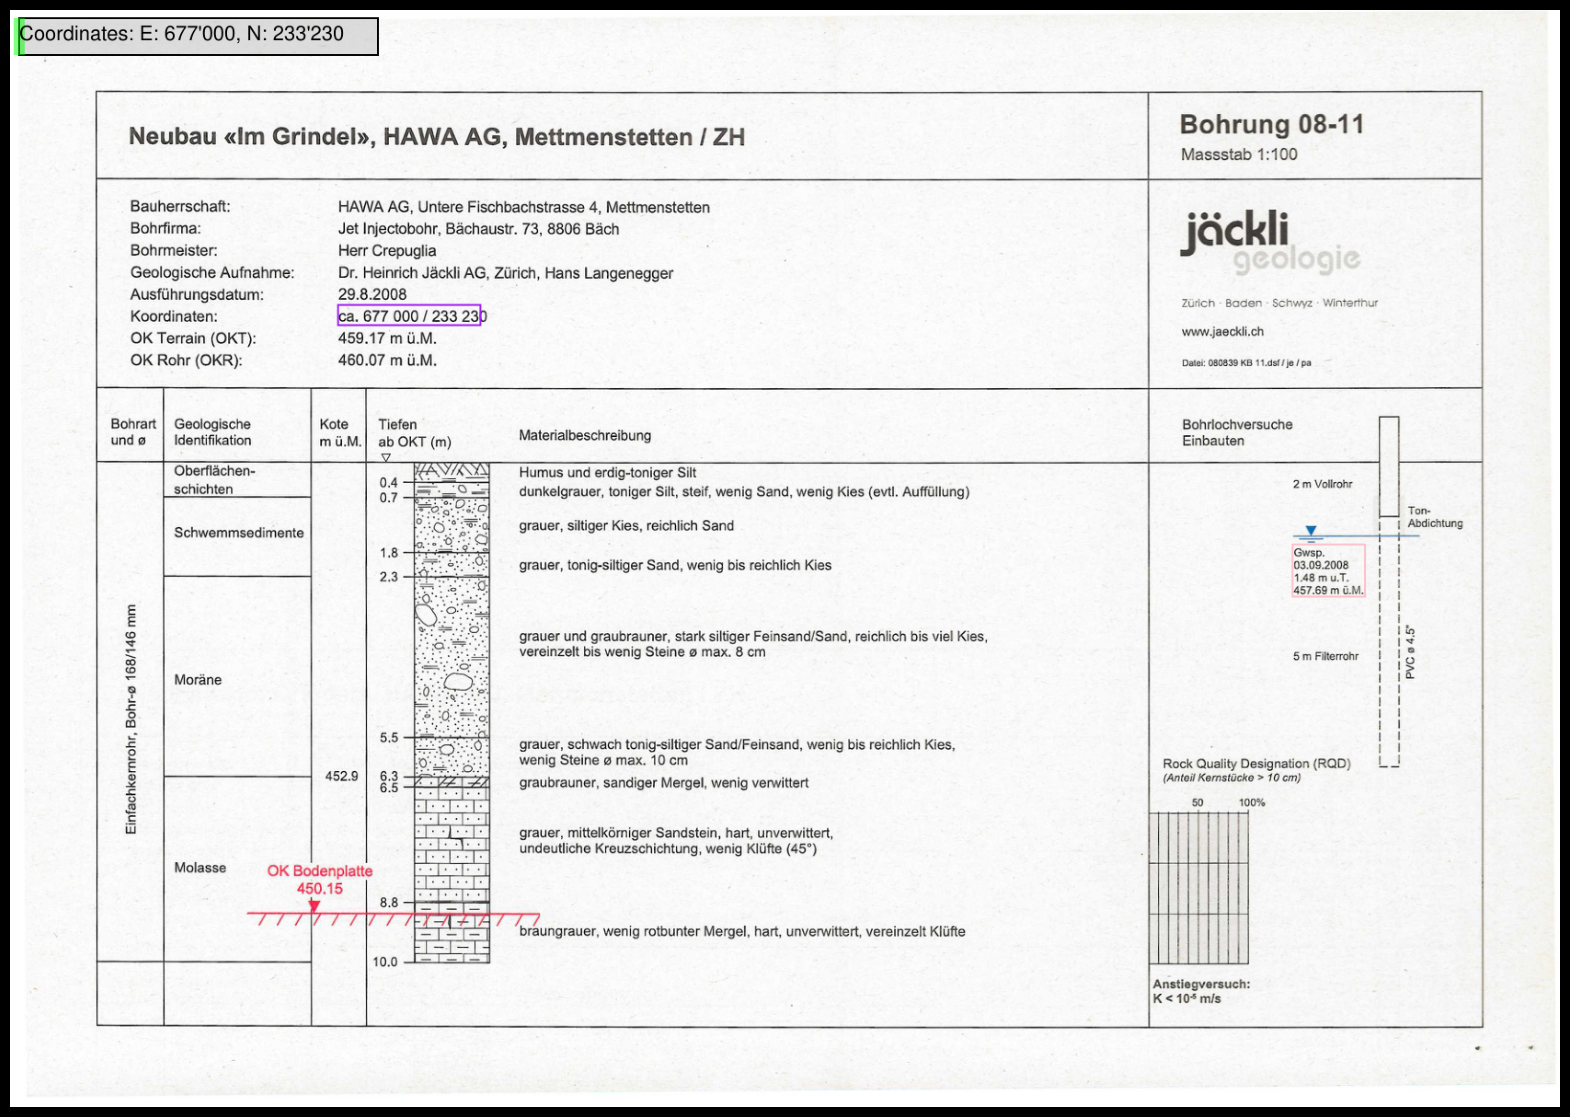

In [18]:
print(draw_directory)
os.makedirs(draw_directory, exist_ok=True)
draw_predictions(predictions_obj, input_directory, draw_directory)

import matplotlib.pyplot as plt

for prediction in predictions.items():
    filename = prediction[0].split(".")[0]
    img = plt.imread(draw_directory / f"{filename}_page1.png")
    plt.figure(figsize=(20, 20))        
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [19]:
assert False

AssertionError: 

# Computer Vision Approach to extract the text from the images

# Find a triangle in an image

source: https://www.geeksforgeeks.org/how-to-detect-shapes-in-images-in-python-using-opencv/

we are going to see how to detect shapes in image. For this we need cv2.findContours() function of OpenCV, and also we are going to use cv2.drawContours() function to draw edges on images. A contour is an outline or a boundary of shape.

In [ ]:
import cv2 
import numpy as np 
from matplotlib import pyplot as plt 
  
# reading image 
filename = "data/zurich/267123055-bp_0.png"
img = cv2.imread(filename) 
  
# converting image into grayscale image 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  
# setting threshold of gray image 
_, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY) 
  
# using a findContours() function 
contours, _ = cv2.findContours( 
    threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
  


In [ ]:
i = 0
  
# list for storing names of shapes 
for contour in contours: 
  
    # here we are ignoring first counter because  
    # findcontour function detects whole image as shape 
    if i == 0: 
        i = 1
        continue
  
    # cv2.approxPloyDP() function to approximate the shape 
    approx = cv2.approxPolyDP( 
        contour, 0.01 * cv2.arcLength(contour, True), True) 
      
    # using drawContours() function 
    cv2.drawContours(img, [contour], 0, (0, 0, 255), 5) 
  
    # finding center point of shape 
    M = cv2.moments(contour) 
    if M['m00'] != 0.0: 
        x = int(M['m10']/M['m00']) 
        y = int(M['m01']/M['m00']) 
  
    # putting shape name at center of each shape 
    if len(approx) == 3: 
        cv2.putText(img, 'Triangle', (x, y), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2) 
  
    # elif len(approx) == 4: 
    #     cv2.putText(img, 'Quadrilateral', (x, y), 
    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2) 
  
    # elif len(approx) == 5: 
    #     cv2.putText(img, 'Pentagon', (x, y), 
    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2) 
  
    # elif len(approx) == 6: 
    #     cv2.putText(img, 'Hexagon', (x, y), 
    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2) 
  
    # else: 
    #     cv2.putText(img, 'circle', (x, y), 
    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2) 
  
# displaying the image after drawing contours 
cv2.imshow('shapes', img)
plt.imshow(img)

plt.savefig("data/zurich/267123055-bp_0_contours.pdf")

# Try to find the groundwater triangle with template matching

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
 
img = cv.imread('data/zurich/267123055-bp_0.png', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
img2 = img.copy()
template = cv.imread('/Users/david.cleres/Desktop/template_2.png', cv.IMREAD_GRAYSCALE)
assert template is not None, "file could not be read, check with os.path.exists()"
w, h = template.shape[::-1]
 
# All the 6 methods for comparison in a list
methods = ['TM_CCOEFF', 'TM_CCOEFF_NORMED', 'TM_CCORR',
            'TM_CCORR_NORMED', 'TM_SQDIFF', 'TM_SQDIFF_NORMED']
 
for meth in methods:
    img = img2.copy()
    method = getattr(cv, meth)
 
    # Apply template Matching
    res = cv.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
 
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
 
    cv.rectangle(img,top_left, bottom_right, (0, 0, 0), 2)
    
    plt.figure(figsize=(100, 100))    
    plt.subplot(121)
    plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122)
    plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
 
    plt.show()